In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import sklearn
import os, pathlib, shutil
import kaggle, kagglehub


Download the competition


In [2]:
competition_name = "home-data-for-ml-course"  # Change this to the competition you want to download
competition_path = pathlib.Path(
    kagglehub.competition.competition_download(competition_name)
)  # Downloads the competition
competition_files: list = os.listdir(competition_path)  # List of the files included in the competition

print(competition_files)

# copy files to the current directory
shutil.copyfile(competition_path / "sample_submission.csv", "sample_submission.csv")
shutil.copyfile(competition_path / "test.csv", "test.csv")
shutil.copyfile(competition_path / "train.csv", "train.csv")

['data_description.txt', 'sample_submission.csv', 'sample_submission.csv.gz', 'test.csv', 'test.csv.gz', 'train.csv', 'train.csv.gz']


'train.csv'

In [3]:
pl.Config.set_tbl_rows(50)
train_df = pl.read_csv(competition_path / "train.csv", infer_schema_length=None)
test_df = pl.read_csv(competition_path / "test.csv", infer_schema_length=None)
sample_submission_df = pl.read_csv(competition_path / "sample_submission.csv")

target_feature_name: str = (set(train_df.columns) - set(test_df.columns)).pop()
target_col = train_df.select(pl.col(target_feature_name))
# print(train_df.schema == test_df.schema)
# df = pl.concat([train_df, test_df])

### EDA


In [12]:
numeric_cols_df = train_df.drop("Id").select(pl.selectors.numeric())
pearson_correlations = (
    numeric_cols_df.select(pl.corr(pl.col("*"), target_feature_name).abs())
    .transpose(include_header=True)
    .sort("column_0", descending=True)
)
spearman_correlations = (
    numeric_cols_df.select(pl.corr(pl.col("*"), target_feature_name, method="spearman").abs())
    .transpose(include_header=True)
    .sort("column_0", descending=True)
)
print(pearson_correlations, spearman_correlations)

shape: (34, 2)
┌───────────────┬──────────┐
│ column        ┆ column_0 │
│ ---           ┆ ---      │
│ str           ┆ f64      │
╞═══════════════╪══════════╡
│ SalePrice     ┆ 1.0      │
│ OverallQual   ┆ 0.790982 │
│ GrLivArea     ┆ 0.708624 │
│ GarageCars    ┆ 0.640409 │
│ GarageArea    ┆ 0.623431 │
│ TotalBsmtSF   ┆ 0.613581 │
│ 1stFlrSF      ┆ 0.605852 │
│ FullBath      ┆ 0.560664 │
│ TotRmsAbvGrd  ┆ 0.533723 │
│ YearBuilt     ┆ 0.522897 │
│ YearRemodAdd  ┆ 0.507101 │
│ Fireplaces    ┆ 0.466929 │
│ BsmtFinSF1    ┆ 0.38642  │
│ WoodDeckSF    ┆ 0.324413 │
│ 2ndFlrSF      ┆ 0.319334 │
│ OpenPorchSF   ┆ 0.315856 │
│ HalfBath      ┆ 0.284108 │
│ LotArea       ┆ 0.263843 │
│ BsmtFullBath  ┆ 0.227122 │
│ BsmtUnfSF     ┆ 0.214479 │
│ BedroomAbvGr  ┆ 0.168213 │
│ KitchenAbvGr  ┆ 0.135907 │
│ EnclosedPorch ┆ 0.128578 │
│ ScreenPorch   ┆ 0.111447 │
│ PoolArea      ┆ 0.092404 │
│ MSSubClass    ┆ 0.084284 │
│ OverallCond   ┆ 0.077856 │
│ MoSold        ┆ 0.046432 │
│ 3SsnPorch     ┆ 0.044584 │

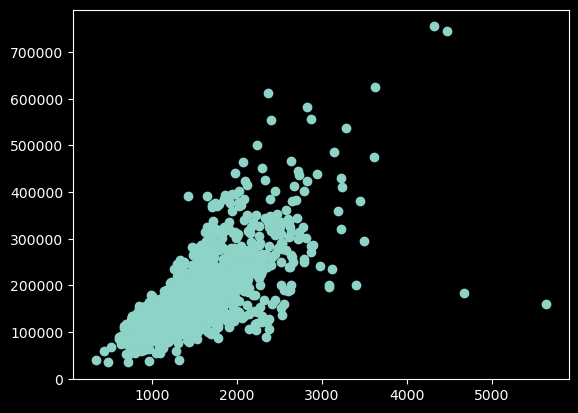

In [44]:
# plt.scatter(train_df.get_column("OverallQual"), train_df.get_column("SalePrice"))
# plt.show()
plt.scatter(train_df.get_column("GrLivArea"), train_df.get_column("SalePrice"))
# plt.yscale("log")
plt.show()
# plt.scatter(train_df.get_column("GarageCars"), train_df.get_column("SalePrice"))
# plt.show()
# plt.scatter(train_df.get_column("GarageArea"), train_df.get_column("SalePrice"))
# plt.show()
# plt.scatter(train_df.get_column("YearBuilt"), train_df.get_column("SalePrice"))
# plt.show()

In [21]:
model = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False)
fit_transformed = model.fit_transform(train_df.select("OverallQual","SalePrice"))

In [53]:
x = train_df.get_column("GrLivArea").to_numpy()
y = train_df.get_column("SalePrice").to_numpy()
X_poly = np.hstack([x, x**2])
model = sklearn.linear_model.LinearRegression().fit(x, y)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

intercept = model.intercept_
coef_x = model.coef_[0]
coef_x2 = 0


ValueError: Expected 2D array, got 1D array instead:
array=[1710 1262 1786 ... 2340 1078 1256].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

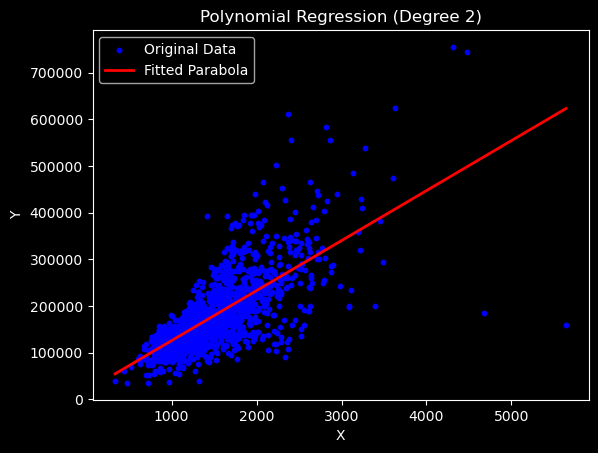

In [52]:

# Scatter plot of the original data
plt.scatter(x, y, color='blue', alpha=1, label="Original Data", s=10)

# Generate smooth x values for plotting the fitted parabola
x_smooth = np.linspace(x.min(), x.max(), 300)  # Smooth range of x values
y_smooth = intercept + coef_x * x_smooth + coef_x2 * (x_smooth ** 2)  # Compute fitted y values

# Plot the fitted parabola
plt.plot(x_smooth, y_smooth, color='red', label="Fitted Parabola", linewidth=2)

# Labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Polynomial Regression (Degree 2)")
plt.legend()
plt.show()
